# 누구에게 프로모션을 제공해야할까?

## 실습 소개
누구에게 타겟 마케팅을 하는 것이 좋을까요?

이번 실습에서는 이전 마케팅 활동에 대한 41,259명의 데이터를 사용하여 머신러닝 모델을 만들어 볼 것입니다.

그리고 새로운 데이터 3,952명에 대해서 실제로 마케팅에 응할 것인지 예측해보고 머신러닝 관점에서 모델을 평가해볼 것입니다.



### (1) 실습 순서
이전 시간에 배웠던 Data Preprocessing이나 Feature Engineering 기법들을 사용하여 데이터를 준비하겠습니다.

데이터가 준비되면 이번 주에 배웠던 내용을 활용해서 알고리즘을 선택하여 모델을 학습하세요.

모델 학습이 완료되면 학습된 모델을 사용하여 3,952명에 대한 테스트가 진행됩니다.
결과는 이번 주 배웠던 Confusion Matrix와 ROC Curve로 확인할 수 있습니다.

### (2) 실습 방법
아래의 스위치 정보를 참고하여 머신러닝 모델을 학습시켜봅니다.

스위치 정보값을 바꿔가며 다양하게 실습해보세요.

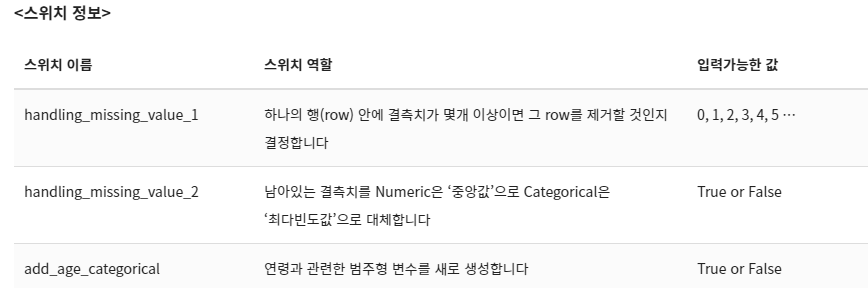
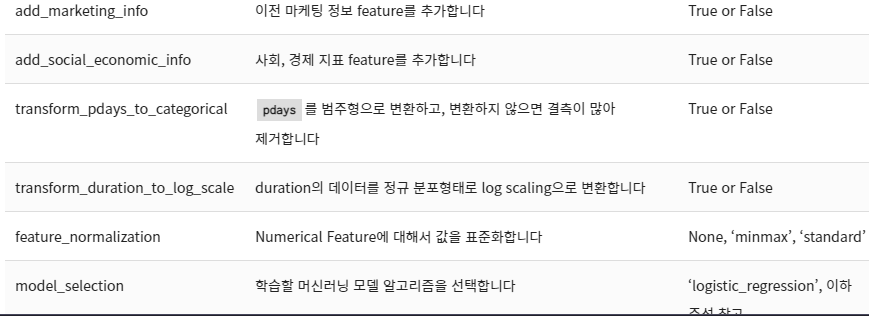

1. 스위치 정보를 참고하여 자유롭게 스위치 정보를 입력해주세요.

2. 실행 버튼을 눌러 입력한 스위치 정보의 Confusion Matrix와 ROC Curve 결과를 확인하세요.

3. 다양한 스위치 정보를 입력해보며 결과를 확인해보세요.
아래와 동일하게 스위치 값을 입력하고, 실행 버튼을 눌러 결과를 확인한 후, 제출 버튼을 눌러보세요.

```
switch = {
    'handling_missing_value_1' : 0,
    'handling_missing_value_2' : True, 
    'add_age_categorical' : True,  
    'add_marketing_info' : True, 
    'add_social_economic_info' : True, 
    'transform_pdays_to_categorical' : False,             
    'transform_duration_to_log_scale' : True, 
    'feature_normalization' :  'standard', 
    'model_selection' :  'decision_tree'
}
```



## 데이터 전처리를 위한 코드


In [ ]:
import math
from time import sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import elice_utils

pd.set_option('display.max_columns', 22)


def execute_machine_learning_system(switch):
    def load_dataset():
        bank = pd.read_csv('bank.csv', sep=';')
        bank.replace('unknown', np.nan, inplace=True)
        bank['y'].replace({'no':0, 'yes':1}, inplace=True)
        return bank
    
    def check_missing_values(df):
        df_null = df.isnull().sum()
        print(">> Bank Marketing 데이터의 변수별 결측치 비율은 다음과 같습니다.")
        for col, val in df_null.items():
            print("{} : {:.2f}%".format(col, val/df.shape[0]*100))
    
    def get_null_columns(df):
        null_sum = df.isnull().sum()
        null_cols = df.columns[np.where(null_sum>0)].values
        print(">> Missing Value가 있는 컬럼 : ", null_cols)
        return null_cols
    
    def set_dtypes(df, num_cols, cat_cols):
        for col in df.columns:
            if col in cat_cols:
                df[col] = df[col].astype(np.object)
            elif col in num_cols:
                df[col] = df[col].astype(np.float)
                
    def label_encoding_categorical(df):
        for col, dtype in zip(df.columns, df.dtypes):
            if dtype == np.object:
                df[[col]] = df[[col]].apply(LabelEncoder().fit_transform)
    
    def create_dataset(df):
        idx = df.dropna(axis=0).index
        test_idx = np.random.RandomState(68).choice(idx, 3952)
        train_idx = ~bank.index.isin(test_idx)
        x = df.drop('y', axis=1).copy()
        y = df[['y']]
        
        x_train = x.loc[train_idx]
        x_test = x.loc[test_idx]
        y_train = y.loc[train_idx].values.ravel()
        y_test = y.loc[test_idx].values.ravel()

        print('>> Create Dataset : 모델 학습을 위해 최종 데이터를 생성합니다.')
        return  x, x_train, x_test, y_train, y_test
    
    
    
    #컨트롤러
    def handling_missing_value(strategy1=None, strategy2=None):
        if strategy1 is None and strategy2 is None:
            print("[INFO] Handling Missing Value : 아무런 정보를 입력하지 않아 실행되지 않습니다.")
            return None
        
        if strategy1 is None: #전략1: 결측치가 있는 row는 제거. 몇개까지 row안에 결측치가 있는지 허용할거냐
            pass
        else:
            remove_missing_value(bank, threshold=strategy1)
            
        if strategy2 is None:
            pass
        else:
            if strategy2:
                fill_missing_value(bank)
            else:
                remove_missing_value(bank, threshold=0)
        sleep(1.2)

    def add_age_categorical(strategy=True):
        if strategy:
            generate_feature_age(bank)
            sleep(1.2)
        else:
            return None        
            
    def add_marketing_info(strategy=True):
        if strategy:
            print('>> Add Marketing Info Features : 이전 마케팅 정보 Feature를 사용합니다.')
            sleep(1.2)
        else:
            remove_past_marketing_info(bank)
    
    def add_social_economic_info(strategy=True):
        if strategy:
            print('>> Add Social & Economic Info Features : 사회, 경제적인 정보 Feature를 사용합니다.')
            sleep(1.2)
        else:
            remove_social_economic_info(bank)  
    
    def transform_pdays_to_categorical(strategy=True):
        if strategy:
            pdays_to_categorical(bank)
            sleep(1.2)
        else:
            return None
    
    def transform_duration_to_log_scale(strategy=True):
        if strategy:
            transform_duration(bank)
            sleep(1.2)
        else:
            return None
    
    def show_result_roc_curve(y_test, y_proba, y_predict, model='choosed_model'):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plot_roc_curve(fpr, tpr, model)
        plt.savefig('roc_curve.svg', format='svg')
        elice_utils.send_image("roc_curve.svg")

    def show_result_confusion_matrix(y_test, y_predict):
        cnf_matrix_ = confusion_matrix(y_true=y_test.squeeze(), y_pred=y_predict)
        plot_confusion_matrix(cnf_matrix_, classes=['Yes','No'], title='Confusion matrix')
        plt.savefig('confusion_matrix.svg', format='svg')
        elice_utils.send_image("confusion_matrix.svg")

    
    #필요함수
    ### Handling Missing Value
    def remove_missing_value(df, threshold=0):
        if type(threshold) != int:
            print("[ERROR] threshold 에는 숫자(int)를 입력해주세요!")
            return None
        if threshold < 0:
            print("[ERROR] 0보다 작은 값을 입력할 수 없습니다.")
            return None
        if threshold > 5:
            threshold = 5
        thresh = df.shape[1] - threshold
        df.dropna(axis=0, thresh=thresh, inplace=True)
        print(">> Handling Missing Value : 결측치가 '제거'되었습니다.")
    
    def fill_missing_value(df):
        # num_cols, cat_cols, null_cols가 선행적으로 assign 되어 있어야 함
        for col in null_cols:
            if col in cat_cols:
                _fill_most_frequent(df, col)
            elif col in num_cols:
                _fill_median(df, col)
            else:
                pass
        print(">> Handling Missing Value : 결측치가 '처리'되었습니다.")
    
    def _fill_most_frequent(df, col):
        most_frequent = df[col].value_counts().index[0] 
        df[col].fillna(most_frequent, inplace=True)
        
    def _fill_median(df, col):
        median = df[col].median()
        df[col].fillna(median, inplace=True)
    
    
    ### Feature Generation
    def generate_feature_age(df):
        df['age_cat'] = pd.cut(df['age'], bins=[0, 25, 45, 60, np.inf], labels=[1, 2, 3, 4])
        cat_cols.append('age_cat')
        print('>> Generate Feature "연령군" : age 변수로부터 새로운 feature를 생성하였습니다.')
    
    
    ### Feature Selection
    def remove_past_marketing_info(df):
        marketing_cols = ['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays']
        df.drop(marketing_cols, axis=1, inplace=True)
        for col in marketing_cols:
            if col in num_cols:
                num_cols.remove(col)
            elif col in cat_cols:
                cat_cols.remove(col)
    
    def remove_social_economic_info(df):
        social_economic_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
        df.drop(social_economic_cols, axis=1, inplace=True)
        for col in social_economic_cols:
            if col in num_cols:
                num_cols.remove(col)
            elif col in cat_cols:
                cat_cols.remove(col)
    
    def choose_model_algorithm(model_selected='logistic_regression'):
        model_list =  ['linear_regression','logistic_regression', 'decision_tree',
					   'knn', 'ridge_regression', 'k-means', 'lasso_regression',
					   'naive_bayes', 'neural_network', 'random_forest'] 
        if model_selected not in model_list:
            s = '''모델 알고리즘을 아래 예시에 있는 것을 정확하게 입력했는지 확인해주세요.\n{}'''.format(model_list)
            raise ValueError(s)
        if model_selected == 'logistic_regression':
            model = LogisticRegression(fit_intercept=False, random_state=1234)
            
        elif model_selected == 'decision_tree':
            model = DecisionTreeClassifier(criterion='gini', random_state=1234)
            
        elif model_selected == 'knn':
            model = KNeighborsClassifier(n_neighbors = 10, weights='uniform', p=2, metric='euclidean')
            
        elif model_selected == 'naive_bayes':
            model =  GaussianNB()
            
        elif model_selected == 'support_vector_machine':
            model = SVC(kernel = 'sigmoid', random_state=1234)
            
        elif model_selected == 'neural_network':
            model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(8, 4), random_state=1234)
            
        elif model_selected == 'random_forest':
            model = RandomForestClassifier(n_estimators = 20, random_state=1234)

        elif model_selected == 'linear_regression':
            s = '''선택한 모델 알고리즘 `{}`은 회귀(regression) 문제에 사용됩니다.\n분류 문제를 위한 모델 알고리즘을 선택해주세요.'''.format(model_selected)
            raise ValueError(s)

        elif model_selected == 'ridge_regression':
            s = '''선택한 모델 알고리즘 `{}`은 회귀(regression) 문제에 사용됩니다.\n분류 문제를 위한 모델 알고리즘을 선택해주세요.'''.format(model_selected)
            raise ValueError(s)

        elif model_selected == 'lasso_regression':
            s = '''선택한 모델 알고리즘 `{}`은 회귀(regression) 문제에 사용됩니다.\n분류 문제를 위한 모델 알고리즘을 선택해주세요.'''.format(model_selected)
            raise ValueError(s)

        elif model_selected == 'k-means':
            s = '''선택한 모델 알고리즘 `{}`은 군집화(clustering) 문제에 사용됩니다.\n분류 문제를 위한 모델 알고리즘을 선택해주세요.'''.format(model_selected)
            raise ValueError(s)

        return model
    
    
    ### Feature Transform
    def pdays_to_categorical(df):
        try:
            pdays = df['pdays']
    
            df.loc[(pdays>=0) & (pdays<5), 'pdays'] = 1
            df.loc[(pdays>=5) & (pdays<10), 'pdays'] = 2
            df.loc[(pdays>=10) & (pdays<15), 'pdays'] = 3
            df.loc[(pdays>=15) & (pdays<20), 'pdays'] = 4
            df.loc[(pdays>=20) & (pdays<25), 'pdays'] = 5
            df.loc[(pdays>=25) & (pdays<999), 'pdays'] = 6
            df.loc[(pdays==999), 'pdays'] = 7
            num_cols.remove('pdays')
            cat_cols.append('pdays')
            print('>> Transform Feature : Feature "pdays"가 Categorical Feature로 변환되었습니다.')
        except KeyError:
            print('[INFO] Transform "pdays" To Categorical : 이전 마케팅 정보를 사용하지 않으므로 실행되지 않습니다.')
    
    def remove_pdays(df):
        df.drop('pdays', axis=1, inplace=True)
        num_cols.remove('pdays')
        
    @np.vectorize
    def log_ignore(x):
        if x != 0:
            return math.log(x)
        else:
            return x
        
    def transform_duration(df):
        try:
            df['duration'] = df['duration'].map(log_ignore)
            print('>> Transform Feature : Feature "duration"이 Log Scale로 변환되었습니다.')
        except:
            print('[INFO] Transform Feature "duration" : 이전 마케팅 정보를 사용하지 않으므로 실행되지 않습니다.')
    
    
    ###
    def cleansing_categorical(indices_categorical_columns):
        categorical_pipline =  Pipeline(steps=[
                        ('select', FunctionTransformer(lambda data: data[:, indices_categorical_columns])),
                        ('onehot', OneHotEncoder(sparse=False))
                    ])
        return categorical_pipline
    
    
    def cleansing_numeric(indices_numeric_columns, how=None):
        if how is None:
            print('>> Feature Normalization : feature의 scale을 그대로 사용합니다.')
            numeric_pipeline = Pipeline(steps=[
                            ('select', FunctionTransformer(lambda data: data[:, indices_numeric_columns])),
                        ])
            return numeric_pipeline
        elif how == 'standard':
            print('>> Feature Normalization : Feature를 Standardization으로 scaling합니다.')
            numeric_pipeline = Pipeline(steps=[
                            ('select', FunctionTransformer(lambda data: data[:, indices_numeric_columns])),
                            ('scale', StandardScaler())
                        ])
            return numeric_pipeline
        elif how == 'minmax':
            print('>> Feature Normalization : Feature를 Min-Max 0과 1사이로 scaling합니다.')
            numeric_pipeline = Pipeline(steps=[
                            ('select', FunctionTransformer(lambda data: data[:, indices_numeric_columns])),
                            ('scale', MinMaxScaler())
                        ])
            return numeric_pipeline
        else:
            s = '[ERROR] Feature Normalization을 위한 방법은 None, "standard", "minmax"로 정확하게 입력하셔야 합니다.'
            raise ValueError(s)
            
    
    def create_estimator(df, model, scaling=None):
        indices_categorical_columns = df.dtypes == np.object
        indices_numeric_columns = df.dtypes != np.object
        if indices_categorical_columns.sum() != 0 and indices_numeric_columns.sum() != 0:
            estimator = Pipeline(steps=[
                ('cleansing', FeatureUnion(transformer_list=[
                    ('categorical', cleansing_categorical(indices_categorical_columns)),
                    ('numeric', cleansing_numeric(indices_numeric_columns, how=scaling))
                ])),
                ('modeling', model)
            ])
        elif indices_categorical_columns.sum() !=0 and indices_numeric_columns.sum() == 0:
            estimator = Pipeline(steps=[
                ('cleansing', FeatureUnion(transformer_list=[
                    ('categorical', cleansing_categorical(indices_categorical_columns))
                ])),
                ('modeling', model)
            ])
        elif indices_categorical_columns.sum() ==0 and indices_numeric_columns.sum() != 0:
            estimator = Pipeline(steps=[
                ('cleansing', FeatureUnion(transformer_list=[
                    ('numeric', cleansing_numeric(indices_numeric_columns, how=scaling))
                ])),
                ('modeling', model)
            ])
        else:
            return None
        return estimator
    
    
    ###
    def plot_roc_curve(fpr, tpr, model, color=None) :
        plt.style.use('seaborn-whitegrid')
    
        accuracy = round(accuracy_score(y_test.squeeze(), y_predict),8)*100
        model = model + '\n(AUC = {:0.3f}, Accuracy={:.2f}%)'.format(auc(fpr, tpr), accuracy)
        
        plt.figure(figsize=(8,8))
        plt.plot(fpr, tpr, label=model, color=color, linewidth=4)
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
        plt.axis([0,1,0,1])
        plt.xlabel('FPR', fontsize=22)
        plt.ylabel('TPR', fontsize=22)
        plt.title('ROC curve', fontsize=35)
        plt.legend(loc="lower right", fontsize=19)
    
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.style.use('seaborn')
        plt.figure(figsize=(7,7))
        import itertools
        if normalize:
            cm = cm.astype('float') / cm.sum()
            title = 'Normalized Rate of Confusion Matrix'
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=35)
        #plt.colorbar( fraction=0.046, pad=0.04, use_gridspec=True)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
        plt.yticks(tick_marks, classes, fontsize=18)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            
            plt.text(j, i, format(cm[~i, ~j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=30)
    
        plt.ylabel('Actual label', fontsize=21)
        plt.xlabel('Predicted label', fontsize=21)
        plt.tight_layout()
        plt.grid(False)
    
    
    
    #전략 선택 부분
    switch_handling_missing_value_1 = switch['handling_missing_value_1']
    switch_handling_missing_value_2 = switch['handling_missing_value_2']
    switch_add_age_categorical = switch['add_age_categorical']
    switch_add_marketing_info = switch['add_marketing_info']
    switch_add_social_economic_info = switch['add_social_economic_info']
    switch_transform_pdays_to_categorical = switch['transform_pdays_to_categorical']
    switch_transform_duration_to_log_scale = switch['transform_duration_to_log_scale']
    switch_feature_normalization = switch['feature_normalization']
    model_selection = switch['model_selection']
    
    #준비
    bank = load_dataset()
    null_cols = get_null_columns(bank)
    num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    
    #전략 실행 부분
    ## Data Preprocessing
    handling_missing_value(strategy1=switch_handling_missing_value_1,
                           strategy2=switch_handling_missing_value_2)
    ### Feature Generation
    add_age_categorical(strategy=switch_add_age_categorical)
    add_marketing_info(strategy=switch_add_marketing_info)
    add_social_economic_info(strategy=switch_add_social_economic_info)
    ### Feature Transform
    transform_pdays_to_categorical(strategy=switch_transform_pdays_to_categorical)
    transform_duration_to_log_scale(strategy=switch_transform_duration_to_log_scale)
    
    # 최종데이터 셋 준비
    set_dtypes(bank, num_cols, cat_cols)
    label_encoding_categorical(bank)
    set_dtypes(bank, num_cols, cat_cols)
    x, x_train, x_test, y_train, y_test = create_dataset(bank)
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=3952, shuffle=True, stratify=y,random_state=13)
    del bank
    
    # 모델학습
    model = choose_model_algorithm(model_selection)
    estimator = create_estimator(x, model, scaling=switch_feature_normalization)
    estimator.fit(x_train, y_train)
    
    # 모델결과
    #model_score = estimator.score(x_test, y_test)
    y_predict = estimator.predict(x_test)
    y_proba = estimator.predict_proba(x_test)[:, 1]
    print('...')
    sleep(1.9)
    print('>>> 모델을 학습하는 중입니다.')
    sleep(1.9)
    print('>>> 모델 학습이 완료되었습니다. 학습된 모델을 사용해 3,952명에 대한 예측을 진행합니다.')
    sleep(3)

    # 시각화
    print('=============================')
    print('========= 예측 결과 =========')
    print('=============================')
    show_result_confusion_matrix(y_test, y_predict)
    sleep(2.2)
    show_result_roc_curve(y_test, y_proba, y_predict, model_selection)


## 메인 코드

In [ ]:
from target_marketing import *



def predictive_model_for_target_marketing():
    
    '''
    아래 준비된 9개의 스위치의 값을 변경하면서
    타겟마케팅을 했을 때 응할 것 같은 고객을 예측하기 위한 머신러닝 모델을 만들어보세요.
    
    ※주의!  "#" 뒤에 있는 값만 입력해주세요!
    '''
    switch = {
        'handling_missing_value_1' : 0, # 0, 1, 2, 3, 4, 5, ...
        'handling_missing_value_2' : True, # True or False
        'add_age_categorical' : True,  #True or False
        'add_marketing_info' : True, #True or False
        'add_social_economic_info' : True, #True or False
        'transform_pdays_to_categorical' : False, #True or False
        'transform_duration_to_log_scale' : True, #True or False
        'feature_normalization' : 'standard', # None, 'minmax', 'standard'
        'model_selection' : 'decision_tree' # ['linear_regression','logistic_regression', 'decision_tree',
                                                  # 'knn', 'ridge_regression', 'k-means', 'lasso_regression',
                                                  # 'naive_bayes', 'neural_network', 'random_forest']    
    }
    
    execute_machine_learning_system(switch)		
    
    return switch


if __name__ == "__main__":
	predictive_model_for_target_marketing()


# 타겟 마케팅의 기대손익과 예상수익 평가하기
## 실습 소개
앞 실습에서 결과로 나온 혼동 행렬(Confusion Matrix)을 이용해서 비즈니스 관점 에서도 그 모델이 다른 모델보다 나은지 확인해보는 실습입니다.


## 실습 순서

1. 이전 실습에서 3,952명에 대해 모델로 예측한 결과를 가져오세요.(Confusion Matrix)
(예시)
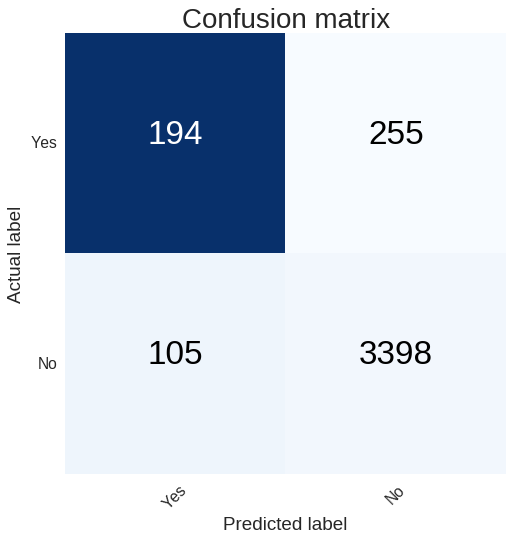

2. 가져온 결과값을 true_positive, false_negative, false_positive, true_negative 변수에 각각 입력해주세요.

3. 각 파트 별로 예상되는 기대손익은 다음과 같습니다.
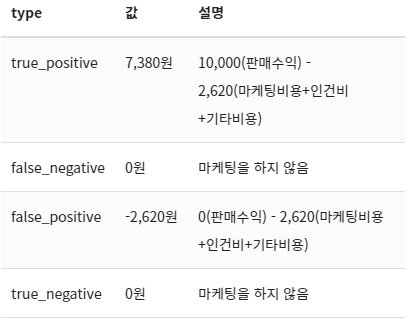

어떤 모델이 가장 비즈니스적으로 성능이 좋은지에 대해 이전 실습의 결과값을 활용해서 모델의 기대손익과 예상 수익을 평가해보겠습니다.

---
1. 이전 실습 ‘누구에게 프로모션을 제공해야할까?’의 3번 지시문의 switch 정보로 학습한 모델의 Confusion Matrix 값을 가져와 예시와 같이 입력하세요.

(예시)
```
true_positive = 94
false_negative = 406
false_positive = 58
true_negative = 3394 
```

**주의! 총 합이 3,952명이어야 합니다.**

이전 실습으로 돌아가 다양한 모델의 Confusion Matrix 값을 가져와 변수에 입력하고, 기대손익과 예상 수익을 평가해보며 비즈니스 관점에서 최고의 모델을 확인해보세요.


In [ ]:
from model_evaluation import *

def evaluate_expected_value():
    
    '''
    [실습] 모델의 기대손익과 예상 수익 평가하기
    
    1) 이전 실습에서 Confusion Matrix의 결과값을 가져오세요
        --------------------------------------
        |                 |                  |
        |  true_positive  |  false_negative  |
        |                 |                  |
        --------------------------------------
        |                 |                  |
        |  false_positive |  true_negative   |
        |                 |                  |
        --------------------------------------
    
    2) 아래에 각 값을 입력하세요 (총 3,952명을 대상으로 합니다)
    
    '''
    
    # 이전 실습에서 Confusion Matrix의 결과값을 가져와 입력하세요
    true_positive = 253
    false_negative = 247
    false_positive = 271
    true_negative = 3181
    
    
    # 모델의 기대손익(expected value)과
    # 모델을 사용했을 때의 예상 수익(revenue)을 확인합니다
    expected_value(
                    true_positive, false_negative,
                    false_positive, true_negative
                    )
    
    
    return true_positive,false_negative,false_positive,true_negative
    
if __name__ == "__main__":
    evaluate_expected_value()


기대 손익 계산 코드

In [ ]:
def expected_value(tp, fn, fp, tn):
    tp_value = 7380
    fn_value = 0
    fp_value = -2620
    tn_value = 0	
    
    total = tp + fn + fp + tn
    actual_true = 500
    input_true = tp + fn
    actual_false = 3952 - actual_true
    input_false = fp + tn
    if total != 3952:
        s = '''예측 대상인 3,952명 보다 많거나 적은 수가 입력되었습니다.\nConfusion Matrix에 적힌 수를 정확하게 입력해주시기 바랍니다.'''
        raise ValueError('{}'.format(s))
    if input_true != actual_true or input_false != actual_false:
        s = '실제(Actual) Maximum True({}) / Minimum False({}) 보다 많거나 적은 값이 입력되었습니다.'.format(actual_true, actual_false)
        raise ValueError(s)
    
    
    ev = (tp/total * tp_value) + (fn/total * fn_value) + (fp/total * fp_value) + (tn/total * tn_value)
    revenue = (tp * tp_value) + (fn * fn_value) + (fp * fp_value) + (tn * tn_value)
    print("개발한 모델의 기대손익은 {:,.0f}원 입니다.".format(ev))
    print("개발한 모델을 사용하여 타겟마케팅을 진행했을 때 예상 수익은 {:,.0f}원 입니다.".format(revenue))
